# Pattern Formation (Three PDE Model)

## Install Required Packages

In [ ]:
pip install py-pde numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.7/333.7 kB 4.0 MB/s eta 0:00:00


## Import Libraries

In [ ]:
from typing import Tuple, Dict, List, Union, Type

from pde import PDEBase, ScalarField, FieldCollection, CartesianGrid, ScipySolver, MemoryStorage
from pde.grids.base import GridBase
from pde.solvers.base import SolverBase

from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

## Definitions

### Define the Pattern Formation PDE Class (Three PDE Model)

In [ ]:
class PatternFormationPDE(PDEBase):
    """Pattern Formation Three PDE Model Class"""

    def __init__(self, params: Dict[str, float], bc: List[Dict[str, float]]) -> None:
        """Initialize the PDE model with parameters.

        Args:
            params (Dict[str, float]): Dictionary of parameters.
            fd_order (int): The order of the FD approximations.
        """

        # Call the base class constructor
        super().__init__()

        # Extract Parameters
        self.D1: float = params["D1"]
        self.D2: float = params["D2"]
        self.D3: float = params["D3"]
        self.k1: float = params["k1"]
        self.k2: float = params["k2"]
        self.k3: float = params["k3"]
        self.k4: float = params["k4"]
        self.k5: float = params["k5"]
        self.k6: float = params["k6"]
        self.k7: float = params["k7"]
        self.k8: float = params["k8"]
        self.k9: float = params["k9"]

        self.bc: List[Dict[str, float]] = bc

    def evolution_rate(self, state: FieldCollection, t: float=0) -> FieldCollection:
        """Compute the evolution rate of the system.

        Args:
            state (FieldCollection): Current state of the system.
            t (float, optional): Current time. Defaults to 0.

        Returns:
            FieldCollection: Evolution rate of the system.
        """

        u1, u2, u3 = state  # Unpack fields

        # Compute gradients with BCs
        grad_u2 = u2.gradient(bc=self.bc)

        # Diffusion terms with BCs
        diff_u1 = self.D1 * u1.laplace(bc=self.bc)
        diff_u2 = self.D2 * u2.laplace(bc=self.bc)
        diff_u3 = self.D3 * u3.laplace(bc=self.bc)

        # Chemotaxis term: -∇·[k1 u1 / (k2 + u2)² ∇u₂]
        chemotaxis_coeff = self.k1 * u1 / (self.k2 + u2) ** 2
        chemotaxis = -chemotaxis_coeff * grad_u2
        chemotaxis_div = chemotaxis.divergence(bc=self.bc)

        # Source terms
        source_u1 = self.k3 * u1 * (
                self.k4 * u3 ** 2 / (self.k9 + u3 ** 2) - u1
        )
        source_u2 = self.k5 * u3 * (
                u1 ** 2 / (self.k6 + u1 ** 2) - self.k7 * u1 * u2
        )
        source_u3 = -self.k8 * u1 * (
                u3 ** 2 / (self.k9 + u3 ** 2)
        )

        # Combine all terms
        du1_dt = diff_u1 + chemotaxis_div + source_u1
        du2_dt = diff_u2 + source_u2
        du3_dt = diff_u3 + source_u3

        return FieldCollection([du1_dt, du2_dt, du3_dt])

### Define Functions used for solving a PDE system

In [ ]:
def set_up_initial_state(grid: GridBase, x_vals: np.ndarray, lambda_val: int=5) -> FieldCollection:
    """Set up the grid and initial state.

    Args:
        grid (GridBase): Grid of x.
        x_vals (np.ndarray): Array of x values.
        lambda_val (int, optional): Initial conditions parameter. Defaults to 5.

    Returns:
        FieldCollection: Initial state values for u1, u2, u3.
    """

    # Gaussian initial profiles centered at x=0
    u1_init = 1e8 * np.exp(-lambda_val * x_vals ** 2)  # cells/ml
    u2_init = 5e-6 * np.exp(-lambda_val * x_vals ** 2)  # M
    u3_init = 1e-3 * np.exp(-lambda_val * x_vals ** 2)  # M

    # Create fields with Neumann BCs specified
    field_u1 = ScalarField(grid, data=u1_init)
    field_u2 = ScalarField(grid, data=u2_init)
    field_u3 = ScalarField(grid, data=u3_init)
    initial_state = FieldCollection([field_u1, field_u2, field_u3])

    return initial_state

def solve_system(pde: PDEBase, solver: Union[SolverBase, str], storage: MemoryStorage, initial_state: FieldCollection, t_range: float, dt: float) -> None:
    """Solve the PDE system and store the results in storage.

    Args:
        pde (PDEBase): PDE model.
        solver (Union[SolverBase, str]): Solver to use.
        storage (MemoryStorage): Storage to use.
        initial_state (FieldCollection): Initial state.
        t_range (float): Range of time to solve for.
        dt (float): Time step.
    """

    trackers = [
        "progress",  # Progress bar
        storage.tracker(interrupts=dt)  # Store every 30 minutes
    ]
    pde.solve(
        state=initial_state,
        t_range=t_range,
        dt=dt,
        solver=solver,
        tracker=trackers
    )

### Define functions used to calculate accuracy

In [ ]:
def get_last_state_results(analysis_points: List[float], x_vals: np.ndarray, u_vals: List[List[float]]) -> Dict[str, Dict[str, np.float64]]:
    """Get the simulation results at certian state

    Args:
        analysis_points (List[float]): The array of x values.
        x_vals (np.ndarray): The array of x values.
        u_vals (List[List[float]]): The list of u1, u2, and u3 values.

    Returns:
        Dict[str, Dict[str, np.float64]]: The simulation results at certian state
    """

    sim_results = {}
    point_indices = [int((x / x_vals[-1]) * (len(x_vals) - 1)) for x in analysis_points]

    for index in range(len(point_indices)):
        x_val = analysis_points[index]
        x_index = point_indices[index]
        u_vals_dict = {}

        u_vals_dict["u1"]: np.float64 = np.array(u_vals[0]).flatten()[x_index]
        u_vals_dict["u2"]: np.float64 = np.array(u_vals[1]).flatten()[x_index]
        u_vals_dict["u3"]: np.float64 = np.array(u_vals[2]).flatten()[x_index]

        sim_results[str(x_val)] = u_vals_dict

    return sim_results

def calc_relative_errors(true_values: Dict[str, Dict[str, float]], approximations: Dict[str, Dict[str, np.float64]]) -> Dict[str, Dict[str, float]]:
    """Calculate the relative error between true values and approximations.

    Args:
        true_values (Dict[str, Dict[str, float]]): The true expected values.
        approximations (Dict[str, Dict[str, np.float64]]): The calculated approximations.

    Returns:
        Dict[str, Dict[str, float]]: The relative errors between true values and approximations as percentages.
    """

    relative_errors: Dict[str, Dict[str, float]] = {}

    for x_val, u_vals in approximations.items():
        relative_errors[x_val] = {}

        for field, value in u_vals.items():
            relative_errors[x_val][field] = (abs(true_values[x_val][field] - value) / true_values[x_val][field]) * 100

    return relative_errors

### Define Functions used for showing the results

In [ ]:
def print_last_state(u_vals: List[List[float]], x_vals: np.ndarray) -> None:
    """Prints the values of x, u1, u2, and u3 for the final state.

    Args:
        u_vals (List[List[float]]): The list of u1, u2, and u3 values.
        x_vals (np.ndarray): The array of x values.
    """

    print(f"\nVerifying with storage data for the final state:")
    print("x (cm)\t\tu1 (cells/ml)\t\tu2 (M)\t\t\tu3 (M)")
    print("-" * 80)

    # Print values from storage
    for j in range(len(x_vals)):
        u1_val: np.float64 = np.array(u_vals[0]).flatten()[j]
        u2_val: np.float64 = np.array(u_vals[1]).flatten()[j]
        u3_val: np.float64 = np.array(u_vals[2]).flatten()[j]

        print(f"{x_vals[j]:.4f}\t\t{u1_val:.4e}\t\t{u2_val:.4e}\t\t{u3_val:.4e}")

def plot_results(data: List[List[List[float]]], x_vals: np.ndarray, time_points: np.ndarray, no_rows: int, no_cols: int, fig_size: Tuple[int, int]) -> None:
    """Plot the results from the storage object in subplots as one figure.

    Args:
        data (List[List[List[float]]]): The list of u1, u2, and u3 values.
        x_vals (np.ndarray): The array of x values.
        no_rows (int): Number of rows in the subplot grid.
        no_cols (int): Number of columns in the subplot grid.
        fig_size (Tuple[int, int]): Size of the figure.
    """

    fig, axes = plt.subplots(no_rows, no_cols, figsize=fig_size)

    for i, (name, ax) in enumerate(zip(["u1", "u2", "u3"], axes)):
        for t_index in range(0, len(time_points)):
            # Flatten the data arrays to 1D
            u_data: np.ndarray = np.array(data[t_index][i]).flatten()

            # Ensure x_vals and data have same length
            if len(x_vals) != len(u_data):
                x_vals: np.ndarray = np.linspace(0, 1, len(u_data))  # Auto-adjust x_vals to match data

            ax.plot(x_vals, u_data, alpha=1.0,
                    label=f"t={time_points[t_index]:.1f} hrs")

        ax.set_title(f"Evolution of {name}")
        ax.set_xlabel("Position x (cm)")
        ax.set_ylabel(name + "(x,t), t=0,0.5,...,5")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def print_relative_errors(true_values: Tuple[str, Dict[str, Dict[str, float]]], approximations: Tuple[str, Dict[str, Dict[str, np.float64]]], relative_errors: Dict[str, Dict[str, float]]) -> None:
    """Prints the relative errors between the book results and the simulation results.

    Args:
        true_values (Tuple[Dict[str, Dict[str, float]]]): Tuple has the column name and the true expected values.
        approximations (Tuple[Dict[str, Dict[str, np.float64]]]): Tuple has the column name and the calculated approximations.
        relative_errors (Dict[str, Dict[str, float]]): The relative errors between true values and approximations as percentages.
    """

    print(f"X (cm)\t\tField\t\t{approximations[0]}\t\t{true_values[0]}\t\tRelative Error")
    print("-" * 105)

    min_error: float = float("inf")
    max_error: float = float("-inf")
    min_error_field: str = ""
    max_error_field: str = ""
    min_error_x: str = ""
    max_error_x: str = ""

    for x_val, u_vals in relative_errors.items():
        print(f"x = {x_val}")

        for field, error in u_vals.items():
            if error < min_error:
                min_error = error
                min_error_field = field
                min_error_x = x_val
            if error > max_error:
                max_error = error
                max_error_field = field
                max_error_x = x_val

            print(f"\t\t{field}\t\t{approximations[1][x_val][field]:.4e}\t\t\t{true_values[1][x_val][field]:.4e}\t\t{error:.2f}%")

    print("-" * 105)
    print("\nError Analysing:")
    print(f"Maximum error: {max_error_field} at x = {max_error_x} with a value of {max_error:.2f}%")
    print(f"Minimum error: {min_error_field} at x = {min_error_x} with a value of {min_error:.2f}%")

### Parameter Definitions

In [ ]:
# Define parameters
params: Dict[str, float] = {
    "D1": 1.999996e-06,     # cm²/s
    "D2": 8.9e-06,          # cm²/s
    "D3": 9.0e-06,          # cm²/s
    "k1": 3.9e-09,          # M·cm²/s
    "k2": 5.0e-06,          # M
    "k3": 1.62e-09,         # h⁻¹·ml/cell (converted from hr⁻¹)
    "k4": 3.5e+08,          # cells/ml
    "k5": 5.0e-07,          # (M·s)⁻¹
    "k6": 1.0e+18,          # (cells/ml)²
    "k7": 1.0e-13,          # ml/(cell·s)
    "k8": 1.0e-14,          # s⁻¹
    "k9": 4.0e-06,          # M²
}

# Define Neumann BCs (zero gradient)
neumann_bc: List[Dict[str, float]] = [{"derivative": 0}, {"derivative": 0}]

# Set up the solver (ScipySolver)
solver: Type[ScipySolver] = ScipySolver  # More robust solver for stiff systems

# Define x boundries
bounds: Tuple[float, float] = (0, 1)

# Define reqiured paremeters for comparing results
time_points: np.ndarray = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) # t values
analysis_points: np.ndarray = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # x values = 0, 0.2, 0.4, 0.6, 0.8, 1 cm

# Book results at t = 5 hours
book_results: Dict[str, Dict[str, float]] = {
                                              "0.0": {"u1": 1.034e7, "u2": 2.480e-6, "u3": 3.449e-4},
                                              "0.2": {"u1": 9.783e6, "u2": 2.384e-6, "u3": 3.358e-4},
                                              "0.4": {"u1": 8.333e6, "u2": 2.133e-6, "u3": 3.116e-4},
                                              "0.6": {"u1": 6.603e6, "u2": 1.824e-6, "u3": 2.803e-4},
                                              "0.8": {"u1": 5.294e6, "u2": 1.576e-6, "u3": 2.541e-4},
                                              "1.0": {"u1": 4.825e6, "u2": 1.481e-6, "u3": 2.438e-4}
                                            }

## The System using grid in x with 51 support points

### PDE System Initialization and Simulation Setup

In [ ]:
# Initiate the PDE system
pde_system: PatternFormationPDE = PatternFormationPDE(params, bc=neumann_bc)

# Create storage to store data and times
storage: MemoryStorage = MemoryStorage()

# Set up grid with 51 points ranged from 0 to 1
number_of_points: int = 51
grid: GridBase = CartesianGrid([bounds], [number_of_points])
x_vals: np.ndarray = np.linspace(bounds[0], bounds[1], number_of_points)

# Set up initial state
initial_state: FieldCollection = set_up_initial_state(grid, x_vals)

### Solve and Print Final State Data

In [ ]:
# Solve the PDE system
solve_system(pde_system, solver, storage, initial_state, t_range=18000, dt=1800)

# Extract data
last_state_index = len(storage.times) - 1 # last index at t = 5 h
u_vals = [
    storage.data[last_state_index][0].data,
    storage.data[last_state_index][1].data,
    storage.data[last_state_index][2].data
]

# Print the last state at t = 5 hours
print_last_state(u_vals, x_vals)

  0%|          | 0/18000.0 [00:00<?, ?it/s]


Verifying with storage data for the final state:
x (cm)		u1 (cells/ml)		u2 (M)			u3 (M)
--------------------------------------------------------------------------------
0.0000		1.0296e+07		2.4961e-06		3.4552e-04
0.0200		1.0353e+07		2.4942e-06		3.4537e-04
0.0400		1.0345e+07		2.4903e-06		3.4495e-04
0.0600		1.0312e+07		2.4846e-06		3.4450e-04
0.0800		1.0270e+07		2.4769e-06		3.4367e-04
0.1000		1.0212e+07		2.4674e-06		3.4293e-04
0.1200		1.0149e+07		2.4561e-06		3.4170e-04
0.1400		1.0070e+07		2.4430e-06		3.4067e-04
0.1600		9.9872e+06		2.4282e-06		3.3905e-04
0.1800		9.8873e+06		2.4117e-06		3.3775e-04
0.2000		9.7867e+06		2.3936e-06		3.3577e-04
0.2200		9.6681e+06		2.3740e-06		3.3421e-04
0.2400		9.5509e+06		2.3529e-06		3.3188e-04
0.2600		9.4157e+06		2.3304e-06		3.3009e-04
0.2800		9.2837e+06		2.3067e-06		3.2745e-04
0.3000		9.1342e+06		2.2817e-06		3.2544e-04
0.3200		8.9895e+06		2.2557e-06		3.2252e-04
0.3400		8.8283e+06		2.2286e-06		3.2032e-04
0.3600		8.6734e+06		2.2007e-06		3.1717e-04
0.3800		8.503

### Plot Results

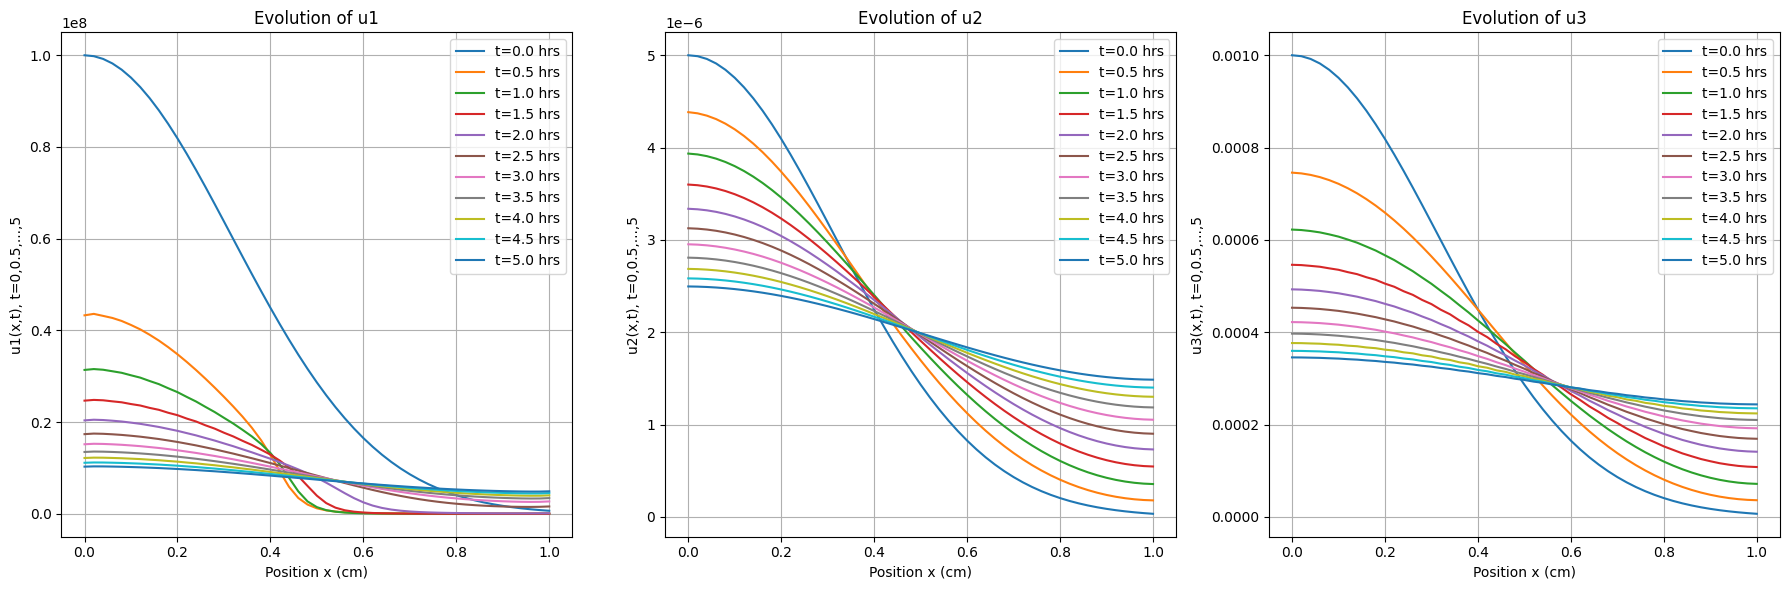

In [ ]:
data: List[List[List[float]]] = [0] * len(time_points)
for t_index in range(0, len(time_points)):
    # Flatten the data arrays to 1D
    u1: np.ndarray = np.array(storage.data[t_index][0].data).flatten()
    u2: np.ndarray = np.array(storage.data[t_index][1].data).flatten()
    u3: np.ndarray = np.array(storage.data[t_index][2].data).flatten()
    data[t_index] = [u1, u2, u3]

plot_results(data, x_vals, time_points, no_rows=1, no_cols=3, fig_size=(18, 6))

### Comparing between learning-based results and chapter results

#### Accuracy

In [ ]:
# Get the simulation results at t = 5 hours and x = 0, 0.2, 0.4, 0.6, 0.8, 1 cm
sim_results = get_last_state_results(analysis_points, x_vals, u_vals)

# Calculate relative error at t = 5 h and x = 0, 0.2, 0.4, 0.6, 0.8, 1 cm
relative_errors: Dict[str, Dict[str, float]] = calc_relative_errors(book_results, sim_results)

# Print relative errors between book results and simulation results
print_relative_errors(("Book Results", book_results), ("Simulation Results", sim_results), relative_errors)

X (cm)		Field		Simulation Results		Book Results		Relative Error
---------------------------------------------------------------------------------------------------------
x = 0.0
		u1		1.0296e+07			1.0340e+07		0.43%
		u2		2.4961e-06			2.4800e-06		0.65%
		u3		3.4552e-04			3.4490e-04		0.18%
x = 0.2
		u1		9.7859e+06			9.7830e+06		0.03%
		u2		2.3936e-06			2.3840e-06		0.40%
		u3		3.3582e-04			3.3580e-04		0.00%
x = 0.4
		u1		8.3396e+06			8.3330e+06		0.08%
		u2		2.1425e-06			2.1330e-06		0.45%
		u3		3.1154e-04			3.1160e-04		0.02%
x = 0.6
		u1		6.6273e+06			6.6030e+06		0.37%
		u2		1.8362e-06			1.8240e-06		0.67%
		u3		2.8067e-04			2.8030e-04		0.13%
x = 0.8
		u1		5.3186e+06			5.2940e+06		0.46%
		u2		1.5873e-06			1.5760e-06		0.72%
		u3		2.5455e-04			2.5410e-04		0.18%
x = 1.0
		u1		4.9208e+06			4.8250e+06		1.98%
		u2		1.4863e-06			1.4810e-06		0.36%
		u3		2.4373e-04			2.4380e-04		0.03%
---------------------------------------------------------------------------------------------------------

Error Ana

#### Time Metrics

| Metric             | learning-based Simulation          | Book Implementation |
| ------------------ | ------------------------------- | ---------------------------- |
| *Runtime*        | 6.922 s (real)                  | Not reported                 |
| *Function Evals* | 10 solver steps                 | 831 ncall                  |
| *Problem Size*   | 153 ODEs (3 fields × 51 points) | 153 ODEs                     |


## Suggestions for improvements and future work

### h Refinement

**Solving the System using grid with higher support points in x (For example nx=101)**

#### PDE System Initialization and Simulation Setup

In [ ]:
# Initiate the PDE system
pde_system_h_refine: PatternFormationPDE = PatternFormationPDE(params, bc=neumann_bc)

# Create storage to store data and times
storage_h_refine: MemoryStorage = MemoryStorage()

# Set up grid with 101 points ranged from 0 to 1
number_of_points_h_refine: int = 101
grid_h_refine: GridBase = CartesianGrid([bounds], [number_of_points_h_refine])
x_vals_h_refine: np.ndarray = np.linspace(bounds[0], bounds[1], number_of_points_h_refine)

# Set up initial state
initial_state_h_refine: FieldCollection = set_up_initial_state(grid_h_refine, x_vals_h_refine)

#### Solve and Print Final State Data

In [ ]:
# Solve the PDE system
solve_system(pde_system_h_refine, solver, storage_h_refine, initial_state_h_refine, t_range=18000, dt=1800)

# Extract data
last_state_index_h_refine = len(storage_h_refine.times) - 1 # last index at t = 5 h
u_vals_h_refine = [
    storage_h_refine.data[last_state_index_h_refine][0].data,
    storage_h_refine.data[last_state_index_h_refine][1].data,
    storage_h_refine.data[last_state_index_h_refine][2].data
]

# Print the last state at t = 5 hours
print_last_state(u_vals_h_refine, x_vals_h_refine)

  0%|          | 0/18000.0 [00:00<?, ?it/s]


Verifying with storage data for the final state:
x (cm)		u1 (cells/ml)		u2 (M)			u3 (M)
--------------------------------------------------------------------------------
0.0000		1.0300e+07		2.4882e-06		3.4519e-04
0.0100		1.0333e+07		2.4877e-06		3.4519e-04
0.0200		1.0343e+07		2.4867e-06		3.4502e-04
0.0300		1.0340e+07		2.4853e-06		3.4500e-04
0.0400		1.0332e+07		2.4833e-06		3.4466e-04
0.0500		1.0318e+07		2.4809e-06		3.4463e-04
0.0600		1.0302e+07		2.4779e-06		3.4411e-04
0.0700		1.0281e+07		2.4745e-06		3.4408e-04
0.0800		1.0260e+07		2.4707e-06		3.4339e-04
0.0900		1.0233e+07		2.4663e-06		3.4335e-04
0.1000		1.0207e+07		2.4615e-06		3.4250e-04
0.1100		1.0174e+07		2.4562e-06		3.4245e-04
0.1200		1.0143e+07		2.4505e-06		3.4143e-04
0.1300		1.0105e+07		2.4443e-06		3.4137e-04
0.1400		1.0068e+07		2.4376e-06		3.4019e-04
0.1500		1.0025e+07		2.4306e-06		3.4012e-04
0.1600		9.9830e+06		2.4231e-06		3.3878e-04
0.1700		9.9346e+06		2.4151e-06		3.3870e-04
0.1800		9.8883e+06		2.4068e-06		3.3721e-04
0.1900		9.834

#### Plot Results

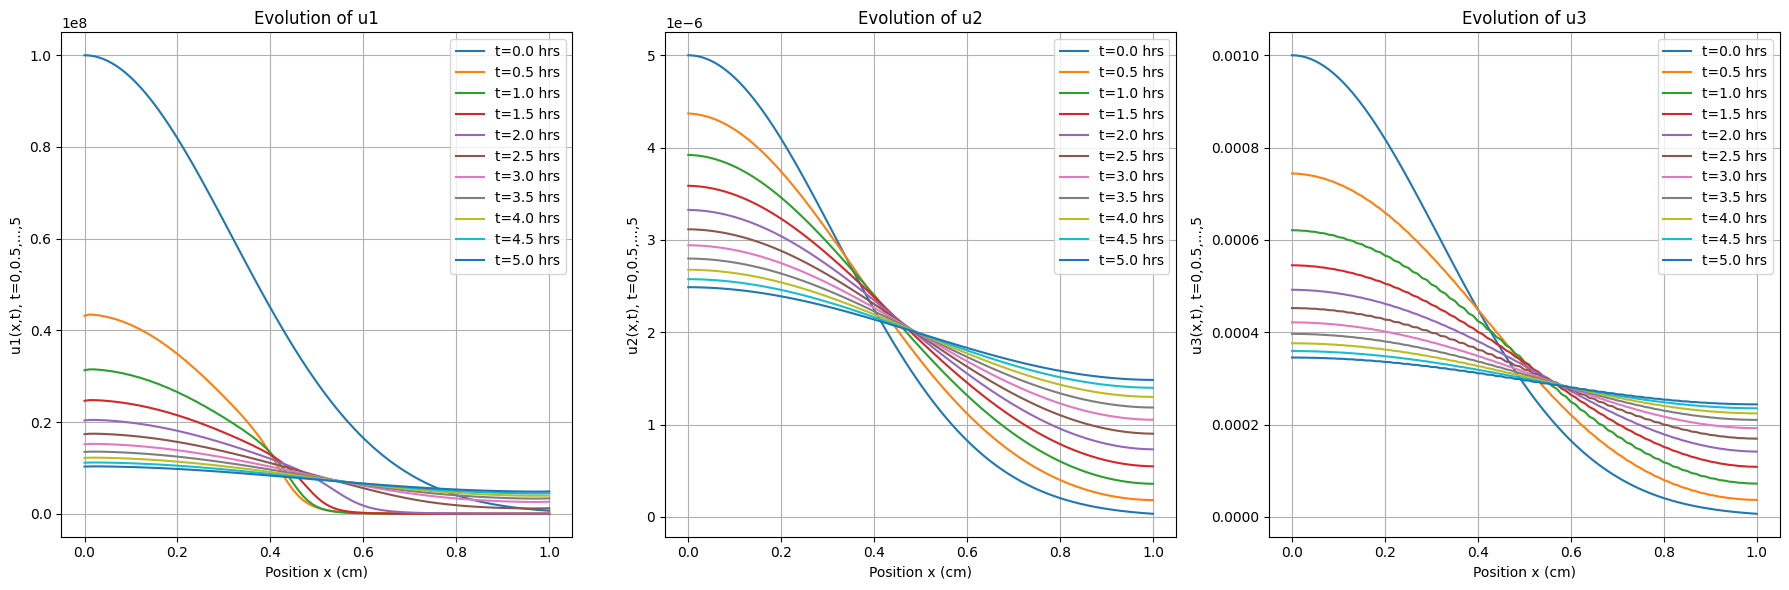

In [ ]:
data_h_refine: List[List[List[float]]] = [0] * len(time_points)
for t_index in range(0, len(time_points)):
    # Flatten the data arrays to 1D
    u1: np.ndarray = np.array(storage_h_refine.data[t_index][0].data).flatten()
    u2: np.ndarray = np.array(storage_h_refine.data[t_index][1].data).flatten()
    u3: np.ndarray = np.array(storage_h_refine.data[t_index][2].data).flatten()
    data_h_refine[t_index] = [u1, u2, u3]

plot_results(data_h_refine, x_vals_h_refine, time_points, no_rows=1, no_cols=3, fig_size=(18, 6))

#### Comparing between results before and after the h refinement

In [ ]:
# Get simulation results at the last state (t = 5 hours)
sim_results_h_refine = get_last_state_results(analysis_points, x_vals_h_refine, u_vals_h_refine)

# Calculate relative error at t = 5 h and x = 0, 0.2, 0.4, 0.6, 0.8, 1 cm
relative_errors: Dict[str, Dict[str, float]] = calc_relative_errors(sim_results, sim_results_h_refine)

# Print relative errors between simulation results before and after h refinement
print_relative_errors(("Simulation before h refinement", sim_results), ("Simulation after h refinement", sim_results_h_refine), relative_errors)

X (cm)		Field		Simulation after h refinement		Simulation before h refinement		Relative Error
---------------------------------------------------------------------------------------------------------
x = 0.0
		u1		1.0300e+07			1.0296e+07		0.04%
		u2		2.4882e-06			2.4961e-06		0.32%
		u3		3.4519e-04			3.4552e-04		0.10%
x = 0.2
		u1		9.7840e+06			9.7859e+06		0.02%
		u2		2.3888e-06			2.3936e-06		0.20%
		u3		3.3548e-04			3.3582e-04		0.10%
x = 0.4
		u1		8.3354e+06			8.3396e+06		0.05%
		u2		2.1379e-06			2.1425e-06		0.22%
		u3		3.1100e-04			3.1154e-04		0.17%
x = 0.6
		u1		6.6141e+06			6.6273e+06		0.20%
		u2		1.8304e-06			1.8362e-06		0.32%
		u3		2.7996e-04			2.8067e-04		0.25%
x = 0.8
		u1		5.3058e+06			5.3186e+06		0.24%
		u2		1.5816e-06			1.5873e-06		0.36%
		u3		2.5398e-04			2.5455e-04		0.22%
x = 1.0
		u1		4.8885e+06			4.9208e+06		0.65%
		u2		1.4837e-06			1.4863e-06		0.17%
		u3		2.4375e-04			2.4373e-04		0.01%
---------------------------------------------------------------------------------------

### p Refinement

**Solve the System using higher-order FD approximations (For example use sixth-order FD approximations)**

Unfortunately, as of now, `py-pde` does not offer built-in 6th-order accurate derivative stencils directly via its public API.